# Part1 - Preprocessing

## Import libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import talib as ta

## Import training set

In [2]:
rsiPeriod = 14
numberOfFeatures = 2

In [3]:
dataTrain = pd.read_csv("/Users/ishan/Coding/Learning/DeepLearning/RNN/Google_Stock_Price_Train.csv") #import csv
dataTrain['CloseEdited'] = dataTrain['Close'].str.replace(",","")
dataTrain['CloseEdited'] = dataTrain['CloseEdited'].astype(float)
dataTrain["RSI"] = ta.RSI(dataTrain['CloseEdited'],rsiPeriod)
newTrain = pd.DataFrame()
newTrain["Open"] = dataTrain['Open']
newTrain['RSI'] = dataTrain['RSI'].fillna(0)
trainingSet = newTrain.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN
trainingSet
ySet = newTrain.iloc[:,0:1].values

## Feature Scaling

In [4]:
# Use normalization x - min(x) / max(min) - min(x)
sc = MinMaxScaler(feature_range=(0,1)) # all values between 0 and 1
ySC = MinMaxScaler(feature_range=(0,1))
ySCSet = ySC.fit_transform(ySet)
scaleTrainingSet = sc.fit_transform(trainingSet)
scaleTrainingSet

array([[0.08581368, 0.        ],
       [0.09701243, 0.        ],
       [0.09433366, 0.        ],
       ...,
       [0.95725128, 0.58260821],
       [0.93796041, 0.56354057],
       [0.93688146, 0.48121379]])

## Create a data structure woth 60 timesteps and 1 output

In [5]:
# Look at the 60 previous timesteps to predict this timestep
xTrain = []
yTrain = []
for i in range(60,1258):
    xTrain.append(scaleTrainingSet[i-60:i])
    yTrain.append(scaleTrainingSet[i])

In [6]:
# convert xtrain and yTrain to numpy for RNN
xTrain, yTrain = np.array(xTrain), np.array(yTrain)

## Reshaping the data

In [7]:
xTrain = np.reshape(xTrain, (xTrain.shape[0],xTrain.shape[1],numberOfFeatures)) #batchsize, inputSize, numberOfFeatures

# Part 2 - Build RNN

## Initalizing the RNN

In [8]:
regressor = Sequential()

## Adding LSTM layers and some dropout regularization

In [9]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (xTrain.shape[1],numberOfFeatures))) 
regressor.add(Dropout(rate = 0.2))

In [10]:
regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(rate = 0.2))

In [11]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [12]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(rate = 0.2))
# Last Layer

## Adding output layer

In [13]:
regressor.add(Dense(units=1))

In [14]:
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [15]:
regressor.fit(xTrain,yTrain,epochs=100,batch_size=32)

Epoch 1/100
38/38 [==============================] - 10s 95ms/step - loss: 0.0707
Epoch 2/100
38/38 [==============================] - 3s 66ms/step - loss: 0.0377
Epoch 3/100
38/38 [==============================] - 3s 67ms/step - loss: 0.0366
Epoch 4/100
38/38 [==============================] - 3s 68ms/step - loss: 0.0360
Epoch 5/100
38/38 [==============================] - 3s 68ms/step - loss: 0.0353
Epoch 6/100
38/38 [==============================] - 3s 68ms/step - loss: 0.0348
Epoch 7/100
38/38 [==============================] - 3s 78ms/step - loss: 0.0341
Epoch 8/100
38/38 [==============================] - 3s 88ms/step - loss: 0.0346
Epoch 9/100
38/38 [==============================] - 3s 74ms/step - loss: 0.0337
Epoch 10/100
38/38 [==============================] - 3s 72ms/step - loss: 0.0333
Epoch 11/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0338
Epoch 12/100
38/38 [==============================] - 3s 70ms/step - loss: 0.0326
Epoch 13/100
38/38 [====

## Part 3 - Predictions and visualing the results

In [16]:
dataTest = pd.read_csv("/Users/ishan/Coding/Learning/DeepLearning/RNN/Google_Stock_Price_Test.csv") #import csv
dataTest["RSI"] = ta.RSI(dataTest['Open'],rsiPeriod).fillna(0)
newTest = pd.DataFrame()
newTest["Open"] = dataTest['Open']
newTest['RSI'] = dataTest['RSI']
realStockPrice = dataTest.iloc[:,1:2].values #convert to numpy to train RNN
newTest

,Open,RSI
0,778.81,0.000000
1,788.36,0.000000
2,786.08,0.000000
3,795.26,0.000000
4,806.40,0.000000
5,807.86,0.000000
6,805.00,0.000000
7,807.14,0.000000
8,807.48,0.000000
9,807.08,0.000000


## Predict price in 2017

In [17]:
datasetTotal = pd.concat((newTrain,newTest),axis=0)
inputs = datasetTotal[len(datasetTotal) - len(newTest) - 60:].values
inputs = sc.transform(inputs)

In [18]:
xTest = []
for i in range(60,80):
    xTest.append(inputs[i-60:i])
xTest = np.array(xTest)
xTest = np.reshape(xTest, (xTest.shape[0],xTest.shape[1],numberOfFeatures)) #batchsize, inputSize, numberOfFeatures

In [19]:
predictedPrice = regressor.predict(xTest)
predictedPrice = ySC.inverse_transform(predictedPrice)


# Visualsing the data

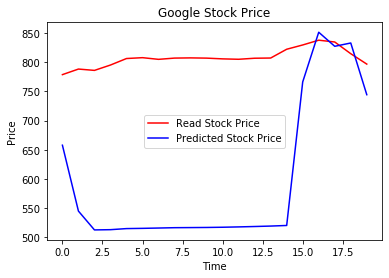

In [20]:
plt.plot(realStockPrice, color = 'red', label = "Read Stock Price")
plt.plot(predictedPrice, color = 'blue', label = "Predicted Stock Price")
plt.title("Google Stock Price")
plt.xlabel('Time')
plt.ylabel("Price")
plt.legend()
plt.show()

In [28]:
stocksOwned = {}
liquidValue = 500_000
for i in range(len(predictedPrice)):
    if realStockPrice[i] < predictedPrice[i] and 'GOOGL' not in stocksOwned:
        stocksOwned['GOOGL'] = (realStockPrice[i], liquidValue/realStockPrice[i])
        liquidValue -= liquidValue/realStockPrice[i] * realStockPrice[i]
    elif 'GOOGL' in stocksOwned and stocksOwned['GOOGL'][0] < realStockPrice[i]:
        liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
        print("in here")
        stocksOwned.pop('GOOGL')
print(liquidValue)

[0.]
